In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from shutil import copyfile
from tqdm import trange, tqdm
from sklearn.metrics import confusion_matrix

import flygym.util.vision as vision
from flygym.util.config import num_ommatidia_per_eye
from flygym.util.data import ommatidia_id_map_path

from vision_model import VisualFeaturePreprocessor


pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [4]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

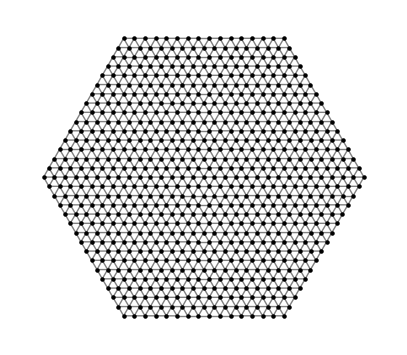

In [5]:
ommatidia_id_map = np.load(ommatidia_id_map_path)
dilation_kernel = np.ones((5, 5), dtype=bool)
edges = set()
node_pos = dict()
for ommatidium_id in range(1, ommatidia_id_map.max() + 1):
    mask_pred = ommatidia_id_map == ommatidium_id
    node_pos[ommatidium_id] = np.mean(np.argwhere(mask_pred), axis=0)
    dilated_mask = ndimage.binary_dilation(mask_pred, dilation_kernel)
    neighbor_ids = np.unique(ommatidia_id_map[dilated_mask])
    for neighbor_id in neighbor_ids:
        if neighbor_id not in [0, ommatidium_id]:
            pair = sorted([ommatidium_id, neighbor_id])
            edges.add(tuple(pair))
graph = nx.from_edgelist(edges)
with open("data/ommatidia_graph.pkl", "wb") as f:
    pickle.dump(graph, f)
pg_graph = pyg.utils.from_networkx(graph)
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(
    graph,
    pos=node_pos,
    node_size=5,
    width=1,
    node_color="black",
    edge_color="gray",
    ax=ax,
)
ax.set_aspect("equal")

In [6]:
with open("data/visual_training_data.pkl", "rb") as f:
    visual_training_data_all = pickle.load(f)

/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


[2.98683371 2.06304382]


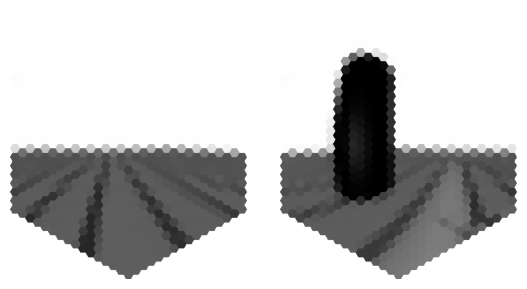

In [7]:
sample_idx = 16
sample = visual_training_data_all[sample_idx]
img_human_l = vision.hex_pxls_to_human_readable(sample["visual_input"][0, :, :])
img_human_r = vision.hex_pxls_to_human_readable(sample["visual_input"][1, :, :])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
axs[0].imshow(img_human_l, cmap="gray", vmin=0, vmax=255)
axs[0].axis("off")
axs[1].imshow(img_human_r, cmap="gray", vmin=0, vmax=255)
axs[1].axis("off")
print(sample["obstacle_position_rel"])

In [8]:
class VisualInputSampleDataset(Dataset):
    fov_lim = np.deg2rad(270 / 2)

    def __init__(self, dataset_path, noise_std=0.05, max_dist=10):
        super().__init__()
        with open(dataset_path, "rb") as f:
            self.dataset = pickle.load(f)
        self.noise_std = noise_std
        self.max_dist = max_dist

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        etr = self.dataset[index]

        # Get input
        intensities = etr["visual_input"].astype(np.float32) / 255
        mask = intensities > 0
        intensities_masked = intensities[mask]
        intensities_masked += np.random.normal(
            scale=self.noise_std, size=intensities_masked.shape
        )
        intensities[mask] = intensities_masked
        intensities = np.clip(intensities, 0, 1)
        intensities = torch.tensor(intensities).float()
        graph_left = pg_graph.clone()
        graph_left.x = intensities[0, :]
        graph_right = pg_graph.clone()
        graph_right.x = intensities[1, :]

        # Get target output
        obstacle_position_rel = etr["obstacle_position_rel"]
        direction = np.arctan2(obstacle_position_rel[1], obstacle_position_rel[0])
        distance = np.linalg.norm(obstacle_position_rel)
        angular_pos = torch.tensor([direction, distance / self.max_dist]).float()

        # Is object found?
        mask = np.array([-self.fov_lim < direction < self.fov_lim])
        mask = torch.tensor(mask).int()[0]

        return {
            "intensity": intensities.float(),
            "graph_left": graph_left,
            "graph_right": graph_right,
            "angular_pos": angular_pos,
            "object_found": mask,
        }

In [9]:
ds = VisualInputSampleDataset("data/visual_training_data.pkl")

In [10]:
def visualize(etr):
    intensities = etr["intensity"].detach().cpu().numpy() * 255
    img_human_l = vision.hex_pxls_to_human_readable(intensities[0, :, :])
    img_human_r = vision.hex_pxls_to_human_readable(intensities[1, :, :])
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
    axs[0].imshow(img_human_l, cmap="gray", vmin=0, vmax=255)
    axs[0].axis("off")
    axs[1].imshow(img_human_r, cmap="gray", vmin=0, vmax=255)
    axs[1].axis("off")
    print(etr["angular_pos"], etr["object_found"])

tensor([1.9929, 0.6544]) tensor(1, dtype=torch.int32)


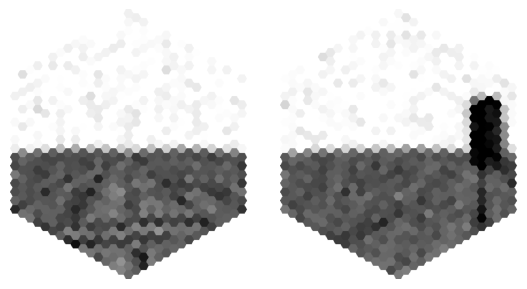

In [11]:
visualize(ds[22])

In [12]:
ds[22]

{'intensity': tensor([[[1.0000, 0.0000],
          [0.0000, 1.0000],
          [1.0000, 0.0000],
          ...,
          [0.3381, 0.0000],
          [0.0000, 0.2835],
          [0.2902, 0.0000]],
 
         [[0.9298, 0.0000],
          [0.0000, 1.0000],
          [0.9602, 0.0000],
          ...,
          [0.3752, 0.0000],
          [0.0000, 0.4251],
          [0.3903, 0.0000]]]),
 'graph_left': Data(edge_index=[2, 4140], num_nodes=721, x=[721, 2]),
 'graph_right': Data(edge_index=[2, 4140], num_nodes=721, x=[721, 2]),
 'angular_pos': tensor([1.9929, 0.6544]),
 'object_found': tensor(1, dtype=torch.int32)}

In [13]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

train_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [0.8, 0.1, 0.1])
train_loader = pyg_loader.DataLoader(
    train_ds, batch_size=32, shuffle=True, num_workers=8
)
val_loader = pyg_loader.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)
test_loader = pyg_loader.DataLoader(
    test_ds, batch_size=32, shuffle=False, num_workers=8
)

In [14]:
model_path = "data/models/visual_preprocessor.pt"
retrain = True

if retrain:
    model = VisualFeaturePreprocessor()
    logger = pl.loggers.TensorBoardLogger("logs/vision", name="visual_preprocessor")
    checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=5, monitor="val_total_loss")
    trainer = pl.Trainer(
        max_epochs=60,
        deterministic=True,
        logger=logger,
        log_every_n_steps=15,
        enable_progress_bar=True,
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    best_model_path = trainer.checkpoint_callback.best_model_path
    print("Best model:", best_model_path)
    copyfile(best_model_path, model_path)

model = VisualFeaturePreprocessor.load_from_checkpoint(model_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


Best model: logs/vision/visual_preprocessor/version_1/checkpoints/epoch=59-step=15000.ckpt


In [15]:
model_cpu = model.to("cpu")
pos_pred_all = np.zeros((len(test_ds), 2))
mask_pred_all = np.zeros((len(test_ds)))
pos_label_all = np.zeros((len(test_ds), 2))
mask_label_all = np.zeros((len(test_ds)))

for i, sample in tqdm(enumerate(test_ds), total=len(test_ds)):
    pos_pred, mask_pred = model_cpu(sample["graph_left"], sample["graph_right"])
    pos_pred = pos_pred.detach().numpy()
    mask_pred = mask_pred.detach().numpy()
    pos_label = sample["angular_pos"].numpy()
    mask_label = sample["object_found"].numpy()
    pos_pred_all[i, :] = pos_pred
    mask_pred_all[i] = mask_pred
    pos_label_all[i, :] = pos_label
    mask_label_all[i] = mask_label

100%|██████████| 1000/1000 [00:01<00:00, 628.82it/s]


In [18]:
angle_r2, distance_r2, detection_f1 = model.get_metrics(
    torch.tensor(pos_pred_all),
    torch.tensor(mask_pred_all),
    torch.tensor(pos_label_all),
    torch.tensor(mask_label_all),
)

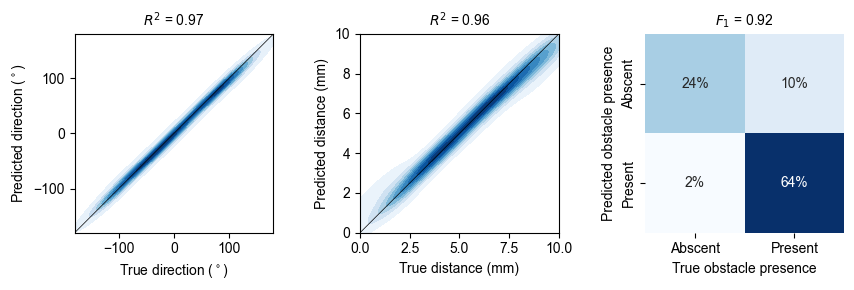

In [23]:
mask = mask_pred_all > 0.5

fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)

ax = axs[0]
sns.kdeplot(
    x=np.rad2deg(pos_label_all[mask, 0]),
    y=np.rad2deg(pos_pred_all[mask, 0]),
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([-180, 180], [-180, 180], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_xlabel(r"True direction ($^\circ$)")
ax.set_ylabel(r"Predicted direction ($^\circ$)")
ax.set_title(f"$R^2$ = {angle_r2:.2f}", fontsize=10)

ax = axs[1]
sns.kdeplot(
    x=pos_label_all[mask, 1] * ds.max_dist,
    y=pos_pred_all[mask, 1] * ds.max_dist,
    fill=True,
    cmap="Blues",
    ax=ax,
)
ax.plot([0, 10], [0, 10], color="black", linewidth=0.5)
ax.set_aspect("equal")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel(r"True distance (mm)")
ax.set_ylabel(r"Predicted distance (mm)")
ax.set_title(f"$R^2$ = {distance_r2:.2f}", fontsize=10)

ax = axs[2]
conf_mat = confusion_matrix(mask_pred_all > 0.5, mask_label_all > 0.5)
sns.heatmap(
    conf_mat / conf_mat.sum(), annot=True, fmt=".0%", cmap="Blues", cbar=False, ax=ax
)
ax.set_aspect("equal")
ax.set_xticklabels(["Abscent", "Present"])
ax.set_yticklabels(["Abscent", "Present"])
ax.set_xlabel("True obstacle presence")
ax.set_ylabel("Predicted obstacle presence")
ax.set_title(f"$F_1$ = {detection_f1:.2f}", fontsize=10)

fig.savefig("outputs/vision_model_stats.pdf", transparent=True)